In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Load Data
df = pd.read_csv(r"C:\Users\Asus\Downloads\full_data_flightdelay.csv\full_data_flightdelay.csv")

# Drop unnecessary columns
cols_to_drop = [
    "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "CARRIER_NAME",  
    "LATITUDE", "LONGITUDE", "PRCP", "SNOW", "SNWD", "AWND", 
    "AVG_MONTHLY_PASS_AIRPORT"
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Handle missing values
df.dropna(inplace=True)

# Categorize DEP_TIME_BLK
def categorize_dep_time(block):
    start_hour = int(block.split('-')[0][:2])
    if 0 <= start_hour < 6:
        return 'Subuh'
    elif 6 <= start_hour < 12:
        return 'Pagi'
    elif 12 <= start_hour < 18:
        return 'Siang'
    elif 18 <= start_hour < 22:
        return 'Sore'
    else:
        return 'Malam'

df['DEP_TIME_CATEGORY'] = df['DEP_TIME_BLK'].apply(categorize_dep_time)
df = df.join(pd.get_dummies(df['DEP_TIME_CATEGORY'], prefix='DEP_TIME').astype(int)).drop(['DEP_TIME_BLK', 'DEP_TIME_CATEGORY'], axis=1)

In [2]:
# Define features and target
X, y = df.drop('CONCURRENT_FLIGHTS', axis=1), df.CONCURRENT_FLIGHTS

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost Model
xgb_reg = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_reg.predict(X_test)

In [3]:
# Evaluate Performance
r2_train_xgb = xgb_reg.score(X_train, y_train)
r2_test_xgb = xgb_reg.score(X_test, y_test)

print(f"Akurasi model pada data training: {r2_train_xgb * 100:.2f}%")
print(f"Akurasi model pada data testing: {r2_test_xgb * 100:.2f}%")

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = math.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"Rata-rata kesalahan prediksi (MAE): {mae_xgb:.2f}")
print(f"Rata-rata kesalahan terbesar (RMSE): {rmse_xgb:.2f}")


Akurasi model pada data training: 81.84%
Akurasi model pada data testing: 81.86%
Rata-rata kesalahan prediksi (MAE): 6.17
Rata-rata kesalahan terbesar (RMSE): 9.16


Top 10 Feature Importances (XGBoost):
AIRPORT_FLIGHTS_MONTH: 0.6152
DEP_TIME_Subuh: 0.0923
DEP_TIME_Malam: 0.0456
AVG_MONTHLY_PASS_AIRLINE: 0.0374
DEP_TIME_Pagi: 0.0291
DAY_OF_WEEK: 0.0199
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0199
GROUND_SERV_PER_PASS: 0.0192
FLT_ATTENDANTS_PER_PASS: 0.0183
DEP_TIME_Siang: 0.0170


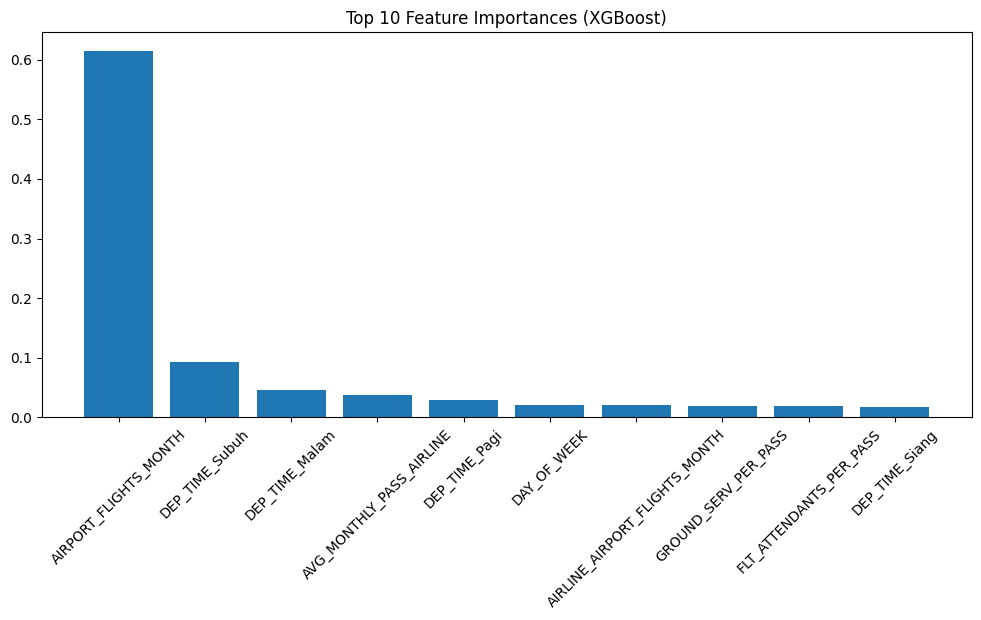

In [4]:
# Feature Importances
importances_xgb = dict(zip(X.columns, xgb_reg.feature_importances_))
sorted_importances_xgb = sorted(importances_xgb.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Feature Importances (XGBoost):")
for feature, importance in sorted_importances_xgb[:10]:
    print(f"{feature}: {importance:.4f}")

# Plot Feature Importances
plt.figure(figsize=(12, 5))
plt.bar([x[0] for x in sorted_importances_xgb[:10]], [x[1] for x in sorted_importances_xgb[:10]])
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


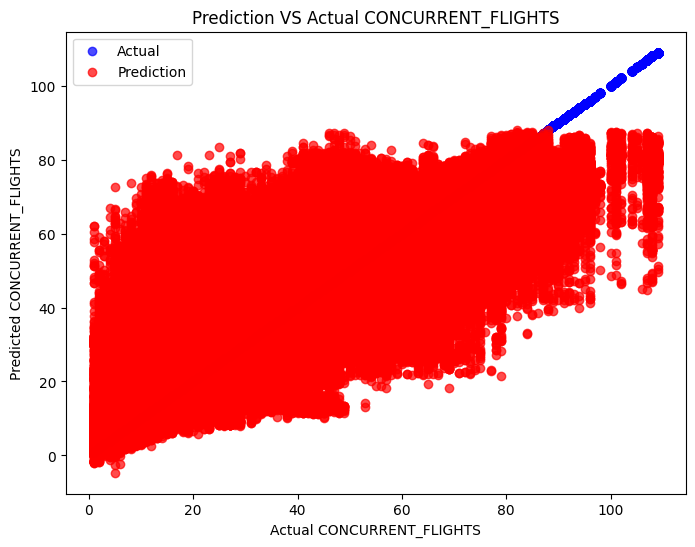

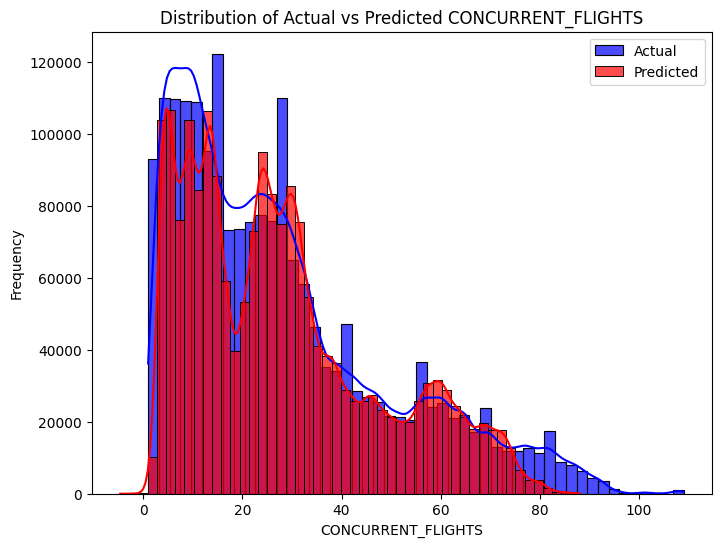

In [5]:
# Visualization - Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(y_test, y_pred_xgb, color='red', label='Prediction', alpha=0.7)
plt.xlabel('Actual CONCURRENT_FLIGHTS')
plt.ylabel('Predicted CONCURRENT_FLIGHTS')
plt.title('Prediction VS Actual CONCURRENT_FLIGHTS')
plt.legend()
plt.show()

# Distribution of Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=50, kde=True, color='blue', alpha=0.7, label='Actual')
sns.histplot(y_pred_xgb, bins=50, kde=True, color='red', alpha=0.7, label='Predicted')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted CONCURRENT_FLIGHTS')
plt.legend()
plt.show()

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


Akurasi model pada data training: 82.82%
Akurasi model pada data testing: 82.81%
Rata-rata kesalahan prediksi (MAE): 5.98
Rata-rata kesalahan terbesar (RMSE): 8.92


Top 10 Feature Importances (XGBoost):
AIRPORT_FLIGHTS_MONTH: 0.5862
DEP_TIME_Subuh: 0.1091
DEP_TIME_Malam: 0.0545
AVG_MONTHLY_PASS_AIRLINE: 0.0359
DEP_TIME_Pagi: 0.0311
DAY_OF_WEEK: 0.0223
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0219
GROUND_SERV_PER_PASS: 0.0197
DEP_TIME_Sore: 0.0181
FLT_ATTENDANTS_PER_PASS: 0.0172


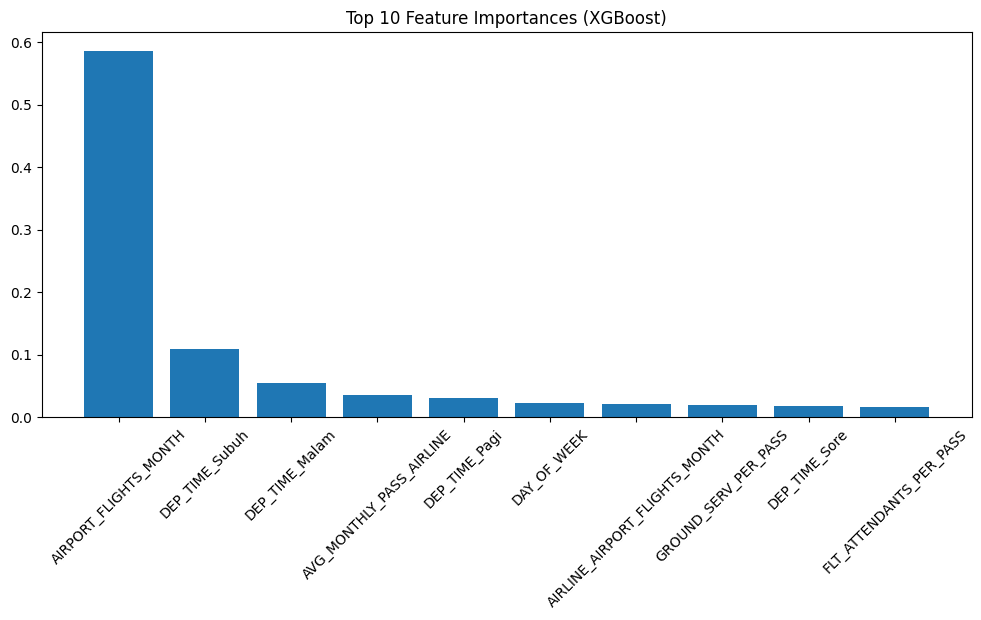

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


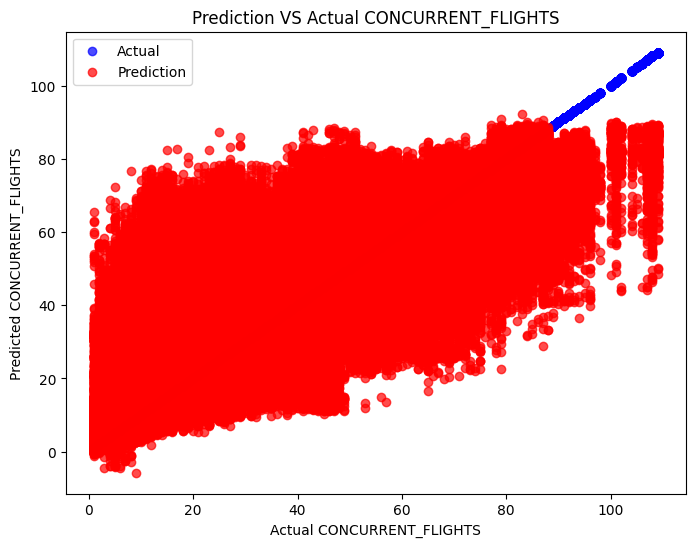

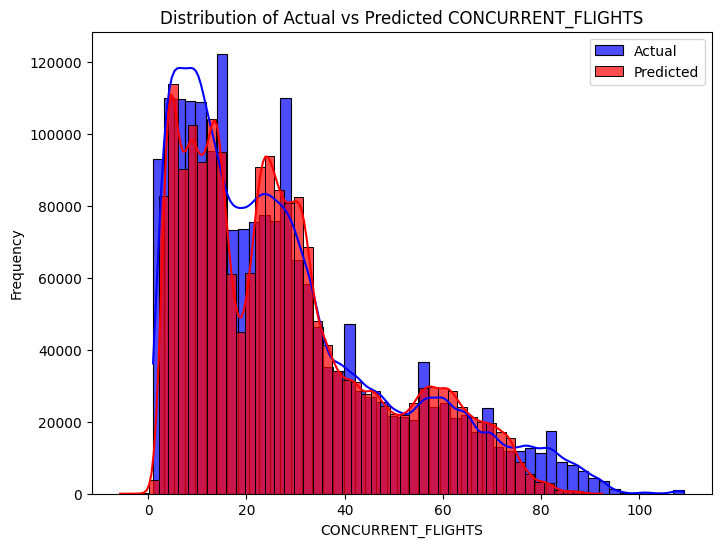

Best Parameters: OrderedDict({'colsample_bytree': 0.7640415835413256, 'learning_rate': 0.044234693745838057, 'max_depth': 10, 'n_estimators': 384, 'subsample': 0.8680591793075738})


Akurasi model pada data training: 86.20%
Akurasi model pada data testing: 85.85%
Rata-rata kesalahan prediksi (MAE): 5.31
Rata-rata kesalahan terbesar (RMSE): 8.09


Top 10 Feature Importances (XGBoost):
AIRPORT_FLIGHTS_MONTH: 0.5384
DEP_TIME_Subuh: 0.1647
DEP_TIME_Malam: 0.0608
AVG_MONTHLY_PASS_AIRLINE: 0.0455
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0381
DEP_TIME_Pagi: 0.0215
GROUND_SERV_PER_PASS: 0.0208
DEP_TIME_Sore: 0.0168
FLT_ATTENDANTS_PER_PASS: 0.0166
AIRLINE_FLIGHTS_MONTH: 0.0141


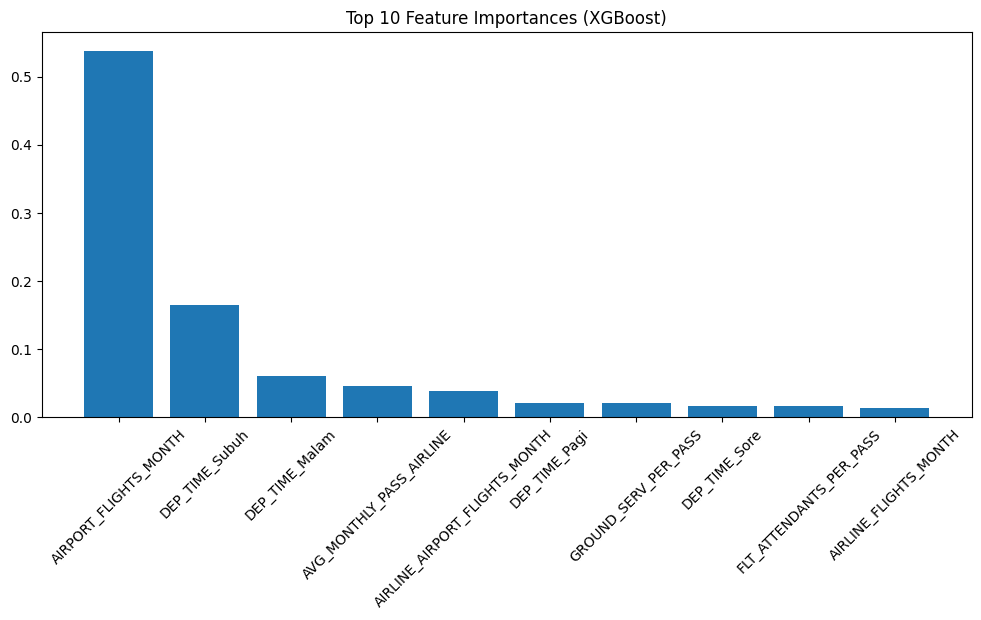

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


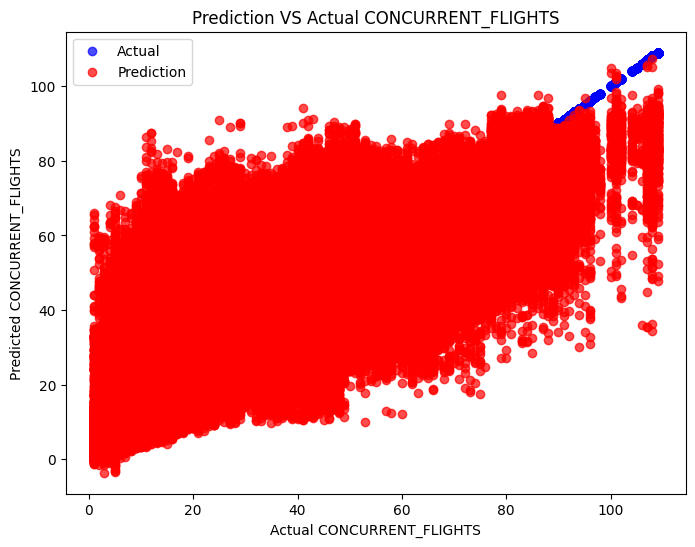

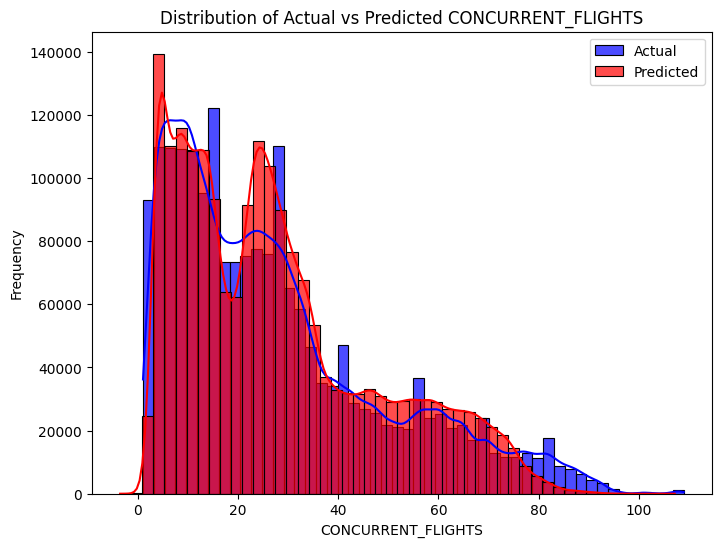